# Reflecting Cosmic Ray analysis
This notebook analyzes pairs of tracks from simulated cosmic ray events, comparing upstream and downstream properties to extract the momentum resolution and shift due to material effects.
It uses root, uproot, and standard python numerical and plotting packages.

In [1]:
import os
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import tensorflow as tf
from pathlib import Path
print("Hello world")

Hello world


This notebook processes TrkAna files constructed using the SelectReflections_module filter.
The TrkAna files contain 4 trees, one for each particle type reconstruction assumption: e+, e-, mu+, and mu-.
Each tree has the same structure, consisting of 2 tracks reconstructed from this particle: trk[0] is the upstream-going fit, trk[1] is the downstream-going fit.

In [4]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
#files = ["/global/cfs/cdirs/m3712/Mu2e/TARef_v7.root:TAReM/trkana"]
#files = ["/data/HD6/users/brownd/TrkAna/TARef_v7.root:TAReM/trkana"]
files = ["/data/HD5/users/brownd/14356147/nts.brownd.TAReflect.TARef.001202_00000000.root:TAReM/trkana"]
    
#time = []
up_up_time = []
up_down_time = []
down_down_time = []
upmcpdg = []
downmcpdg = []
up_px = []
up_py = []
up_pz = []
down_px = []
down_py = []
down_pz = []
nipa_up = []
nipa_down = []
nst_up = []
nst_down = []
for batch,rep in uproot.iterate(files,filter_name="/trk|trkfit|trkmcsim/i",report=True):
    # print("Fields available in 'trkfit':", ak.fields(batch["trkfit"]))
    # upstream and downstream tracks
    upstream = batch["trkfit"][:,0]
    downstream = batch["trkfit"][:,1]
    uptrkmcsim = batch["trkmcsim"][:,0][:,0] # primary MC particle matched to the upstream track
    downtrkmcsim = batch["trkmcsim"][:,1][:,0] # primary MC particle matched to the downstream track
    # find the samples at the tracker entrance
    up_up = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] < 0) # exiting the tracker
    up_down = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] > 0) # re-entering the tracker
    down_down = (downstream["sid"] == 0) & (downstream['mom']['fCoordinates']['fZ'] > 0) # entering the tracker
    has_up_up = ak.num(upstream[up_up]) > 0
    has_up_down = ak.num(upstream[up_down]) > 0
    has_down_down = ak.num(downstream[down_down]) > 0
    has_all = has_up_up & has_up_down & has_down_down
    up_up_time.extend(ak.flatten(upstream[has_all][up_up]['time']))
    up_down_time.extend(ak.flatten(upstream[has_all][up_down]['time']))
    down_down_time.extend(ak.flatten(downstream[has_all][down_down]['time']))
    upmcpdg.extend(uptrkmcsim['pdg'])
    downmcpdg.extend(downtrkmcsim['pdg'])
    up_px.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fX']))
    up_py.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fY']))
    up_pz.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fZ']))
    down_px.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fX']))
    down_py.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fY']))
    down_pz.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fZ']))
    #nipa_up.extend(uptrk['nipaup'])
    nipa_up.extend(batch["trk.nipaup"][:,0]) # only need upstream track for material intersection counting
    nipa_down.extend(batch["trk.nipadown"][:,0])
    nst_up.extend(batch["trk.nstup"][:,0])    
    nst_down.extend(batch["trk.nstdown"][:,0])
deltapdg = np.subtract(upmcpdg,downmcpdg)
decay = []
for dpdg in deltapdg :
    decay.append(dpdg != 0)
decay = np.array(decay)

#print("NIPA_up",len(nipa_up),nipa_up[:10])

up_px = np.square(up_px)
up_py = np.square(up_py)
up_pz = np.square(up_pz)
down_px = np.square(down_px)
down_py = np.square(down_py)
down_pz = np.square(down_pz)
up_mom = np.sqrt(up_px + up_py + up_pz)
down_mom = np.sqrt(down_px + down_py + down_pz)

nipa = np.add(nipa_up,nipa_down)
nst = np.add(nst_up,nst_down)
nmat = np.add(nipa,nst)

print("Upstream momentum ",up_mom[:10])
print("Downstream momentum ",down_mom[:10])
print("Upstream fit upstream time ",len(up_up_time),up_up_time[:10])
print("Upstream fit downstream time",len(up_down_time),up_down_time[:10])
print("Downstream fit downstream time",len(down_down_time),down_down_time[:10])
print("Upstream MC PDG code",len(upmcpdg),upmcpdg[:10])
print("Downstream MC PDG code",len(downmcpdg),downmcpdg[:10])
print("Decays ",decay.sum())    
print("N ST ",nst[:10]," N IPA ",nipa[:10], "N mat ", nmat[:10])

Upstream momentum  [ 96.22888  159.04433  108.7314   115.91711  154.39935   76.58741
  86.00765   82.237236  42.686844  95.90843 ]
Downstream momentum  [ 91.74794  158.50298  107.89777  115.440384 148.71686   76.4352
  85.37698   81.77832   42.078354  96.482445]
Upstream fit upstream time  4086 [683.4599968917897, 544.8873809494154, 1536.1834295096999, 843.5298471281699, 961.3227243068469, 1605.2462386032093, 469.93802364712855, 821.6052864690405, 1028.231056484006, 1350.2475837109314]
Upstream fit downstream time 4086 [735.237951261851, 604.8757982131439, 1588.4968390770036, 894.3175123070978, 1018.1510385037776, 1652.8538201817014, 523.3773437689185, 898.5943921488558, 1094.6141731563455, 1406.796927545972]
Downstream fit downstream time 4086 [732.9411153432106, 624.5567778822373, 1588.8382828599572, 893.9732439732288, 1038.0216123637585, 1653.8341446120492, 518.0807285484058, 905.4232317121895, 1084.5938208701486, 1406.2290089024134]
Upstream MC PDG code 4086 [11, 13, 11, 11, 13, 11

Label true elec

In [5]:
true_em = []
true_mum = []
for mcpdg in upmcpdg :
    true_em.append(mcpdg == 11)
    true_mum.append(mcpdg == 13)
true_em = np.array(true_em)
true_mum = np.array(true_mum)
print("True Electrons",len(true_em),true_em[:10])
print("True Muons",len(true_mum),true_mum[:10])


True Electrons 4086 [ True False  True  True False  True  True  True  True  True]
True Muons 4086 [False  True False False  True False False False False False]


N true electrons  3581  N true muons  504


<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_977439/327429269.py:6: SyntaxWarning: invalid escape sequence '\D'
  ehist = ax.hist(em_time_diff,label="True $e^-$ $\Delta$ T", bins=100,range=(-25,25))
/tmp/ipykernel_977439/327429269.py:7: SyntaxWarning: invalid escape sequence '\m'
  muhist = ax.hist(mum_time_diff,label="True $\mu^-$ $\Delta$ T", bins=100,range=(-25,25))


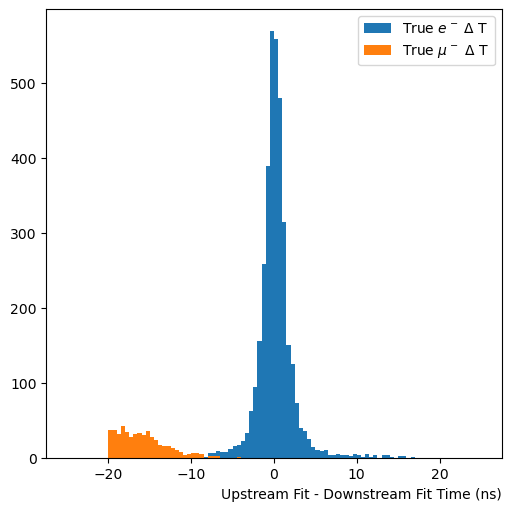

In [6]:
time_diff = np.array(up_down_time) - np.array(down_down_time)
em_time_diff = time_diff[true_em]
mum_time_diff = time_diff[true_mum]
print("N true electrons ",len(em_time_diff), " N true muons ", len(mum_time_diff))
fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
ehist = ax.hist(em_time_diff,label="True $e^-$ $\Delta$ T", bins=100,range=(-25,25))
muhist = ax.hist(mum_time_diff,label="True $\mu^-$ $\Delta$ T", bins=100,range=(-25,25))
ax.set_xlabel('Upstream Fit - Downstream Fit Time (ns)',loc='right')
ax.legend()

In [7]:
abs_time_diff = np.absolute(time_diff)
good_em = []
max_tdiff = 5.0
for tdiff in abs_time_diff :
    good_em.append( tdiff <  max_tdiff)
print("Good electron ",len(good_em),good_em[:10])
good_em = np.array(good_em)
true_good_em = good_em[true_em]
eff = good_em.sum()/true_em.sum()
pur = true_good_em.sum()/good_em.sum()
print("For Delta T < ", max_tdiff , " efficiency = ",eff," purity = ",pur)

Good electron  4086 [True, False, True, True, False, True, False, False, False, True]
For Delta T <  5.0  efficiency =  0.9603462719910639  purity =  0.9997092177958709


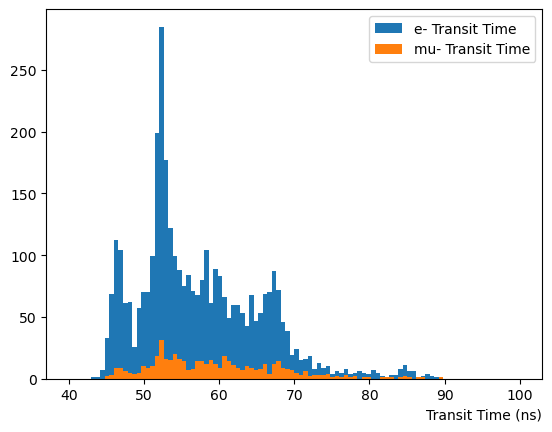

In [8]:
transit_time = np.array(up_down_time) - np.array(up_up_time)
em_transit_time = transit_time[true_em]
mum_transit_time = transit_time[true_mum]
plt.hist(em_transit_time,label="e- Transit Time", bins=100,range=(40,100))
plt.hist(mum_transit_time,label="mu- Transit Time", bins=100,range=(40,100))
plt.xlabel('Transit Time (ns)', loc='right')
plt.legend()

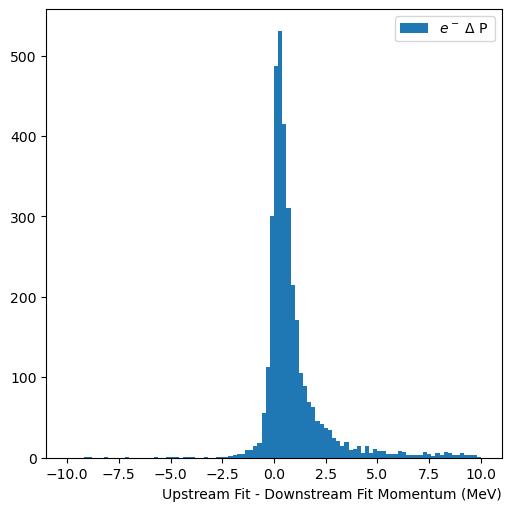

In [17]:
mom_diff = up_mom - down_mom
nomat = []
for nm in nmat :
    nomat.append( nm ==0 )
nomat = np.array(nomat)
good_em_nomat = np.logical_and(nomat,good_em)

em_mom_diff = mom_diff[good_em] # THIS IS THE IMPORTANT ONE
em_mom_diff_nomat = mom_diff[good_em_nomat]
nmat_good = nmat[good_em]
up_mom_good = up_mom[good_em]

#fig, (ax0, ax1, ax2)  = plt.subplots(1,3,layout='constrained', figsize=(15,4))
fig, (ax0)  = plt.subplots(1,1,layout='constrained', figsize=(5,5))
#ax0.hist(em_mom_diff,label="$e^-$ $\Delta$ P", histtype='step', bins=100,range=(-10,10))
ax0.hist(em_mom_diff,label="$e^-$ $\\Delta$ P",bins=100,range=(-10,10))
#ax0.hist(em_mom_diff_nomat,label="e- Upstream - Downstream Momentum (No Material)", histtype='step', bins=100,range=(-10,10))
ax0.set_xlabel("Upstream Fit - Downstream Fit Momentum (MeV)",loc='right')
ax0.legend()
#ax1.hist2d(nmat_good,em_mom_diff,bins=(15,100),range=([0,15],[-5,5]),norm=mpl.colors.LogNorm())
#ax1.set_xlabel("N Material Xings",loc='right')
#ax1.set_ylabel("Delta P (MeV)",loc='top')
#ax2.hist2d(up_mom_good,em_mom_diff,bins=(20,100),range=([40,150],[-5,5]),norm=mpl.colors.LogNorm())
#ax2.set_xlabel("Upstream P (MeV)",loc='right')
#ax2.set_ylabel("Delta P (MeV)",loc='top')

# standard fit error is sqr(y val)

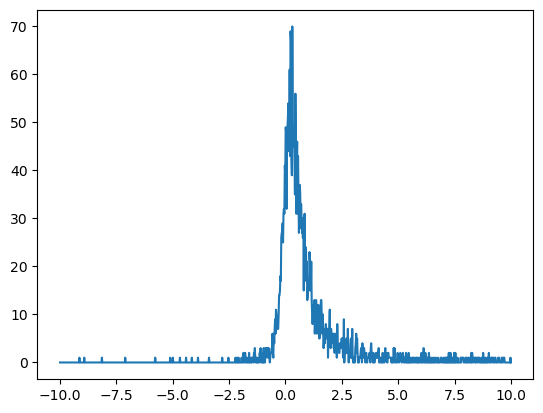

In [10]:
# let's make this look more like a line graph

N = 1024

xdata = np.linspace(-10, 10, N)
ydata = np.zeros(shape=N)

for i in range(N-1):
    for j in range(len(em_mom_diff)):
        if em_mom_diff[j] >= xdata[i] and em_mom_diff[j] < xdata[i+1]:
            count = ydata[i]
            count = count + 1
            ydata[i] = count

plt.plot(xdata, ydata)
plt.show()

# err of y = sqrt(y)

In [11]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [12]:
from scipy.optimize import curve_fit
import math
from scipy import special

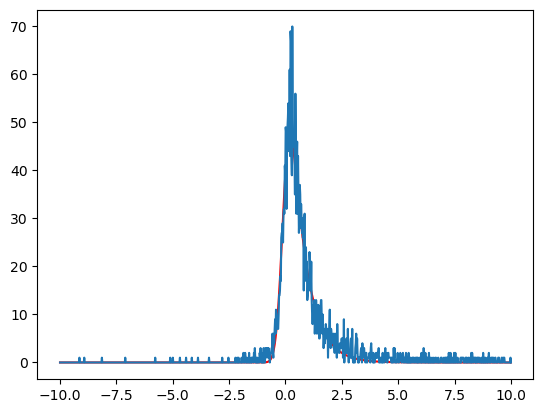

[57.63898631 -0.08257462  0.24132594  1.47840006]
[[ 5.60941172e-01 -1.04977030e-04 -4.86226967e-05 -6.30770513e-04]
 [-1.04977030e-04  8.27988004e-05  4.25648531e-05  1.97371193e-04]
 [-4.86226967e-05  4.25648531e-05  6.26315273e-05  1.19481718e-04]
 [-6.30770513e-04  1.97371193e-04  1.19481718e-04  9.90549350e-04]]


In [13]:
def fxn_expGauss(x, amp, mu, sigma, lamb):
    z = (mu + lamb*(sigma**2) - x)/(np.sqrt(2)*sigma)
    #comp_err_func = 1 - (2*z)/(np.sqrt(math.pi)) + (2*(z**3))/(3*np.sqrt(math.pi)) - (z**5)/(5*np.sqrt(math.pi)) # Taylor approximation
    comp_err_func = special.erfc(z)
    
    val = amp*(lamb/2)*((math.e)**((lamb/2)*(2*mu+lamb*(sigma**2)-2*x)))*comp_err_func
    return val
    
sigma_val = np.empty(shape=N)

for i in range(N):
    sigma_val[i] = max(np.sqrt(ydata[i]), 1)
    
ysum = np.sum(ydata)
mu_0 = np.mean(xdata*ydata/ysum)
var = np.sum(((xdata**2)*ydata)/ysum) - mu_0**2
sigma_0 = np.sqrt(var)
lamb_0 = 0
amp_0 = ysum*(20/1024)
p0 = np.array([amp_0, mu_0, sigma_0, lamb_0])

popt, pcov = curve_fit(fxn_expGauss, xdata, ydata, p0, sigma=sigma_val)
plt.plot(xdata, fxn_expGauss(xdata, *popt), 'r-')
plt.plot(xdata, ydata)
plt.show()

print(popt)
print(pcov)


In [14]:
err_diag = np.empty(shape=4)

for j in range(4):
    err_diag[j] = np.sqrt(pcov[j][j])

print(err_diag)

[0.74896006 0.00909938 0.00791401 0.03147299]


In [15]:
# for each bin, np.sum((y func - y act)**2/sigma_y**2)

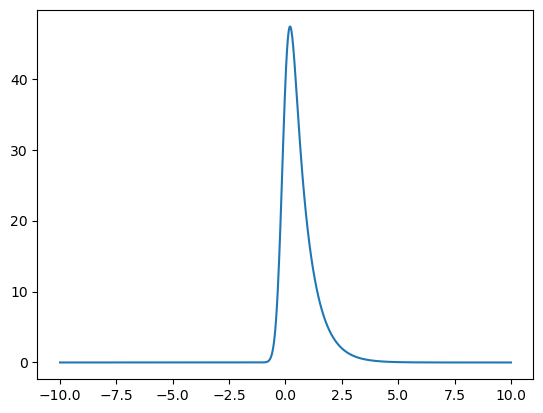

The chi squared value is: 504.9277534186912


In [16]:
y_func = np.empty(shape=N)
amp_op = popt[0]
mu_op = popt[1]
sigma_op = popt[2]
lamb_op = popt[3]

for n in range(N):
    y_func[n] = fxn_expGauss(xdata[n], amp_op, mu_op, sigma_op, lamb_op)

plt.plot(xdata, y_func)
plt.show()
    
chi_square = np.sum(((y_func - ydata)/sigma_val)**2)

print("The chi squared value is:", chi_square)